In [1]:
# Generate NCI reports for given projects
import os
import sys

user_id = os.environ['USER']

# Insert your local paths here
sys.path.append(f'/home/548/{user_id}/code/nci_resource_tools')
sys.path.append(f'/home/548/{user_id}/code/nci-tools/src/ncitools')


In [2]:
import pandas as pd
import subprocess 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display
import datetime as dt

from nci_account import nci_account
from nci_resource_tools.read_project import retrieve_project_data, create_storage_df
from config import *

In [3]:
COE_PROJECTS

['gb02', 'fy29', 'if69', 'ng72', 'su28']

In [4]:
USE_DU

False

In [5]:
SU_df_dict, grant_dict, storage_dict = retrieve_project_data()

Text(0.5, 0.98, 'SU usage as of Wednesday April 30 2025')

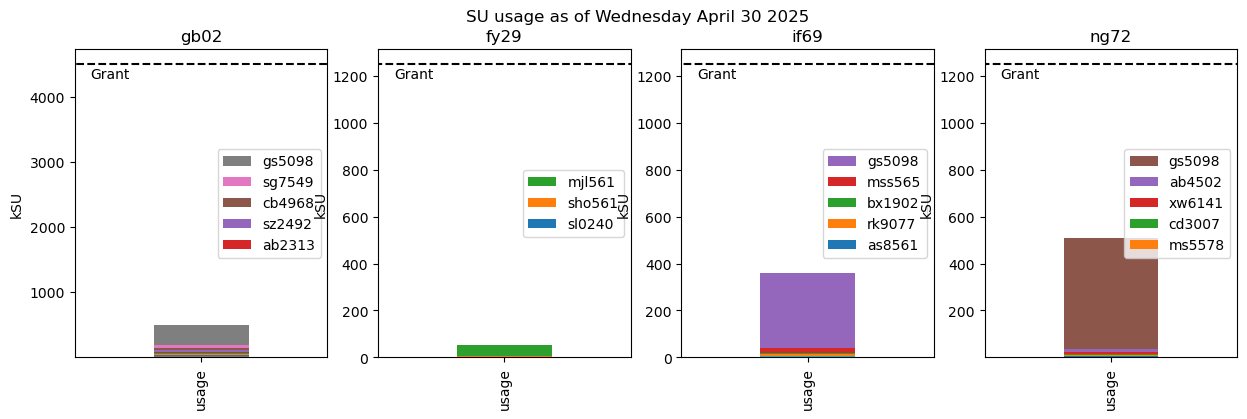

In [6]:
# Plot kSUs for every project
fig,axes = plt.subplots(1,len(grant_dict),figsize=(15,4))

USER_NAMES = 5  #Plot the top five usernames of SU usage

for i,project in enumerate(grant_dict.keys()):
    
    SU_df_dict[project]['usage'].sort_values(ascending=True).to_frame().T.plot.bar(stacked=True,ax=axes[i],width=0.3)
    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1],loc=7)
    axes[i].hlines(grant_dict[project],-5,5,linestyles='dashed',color='black')
    axes[i].annotate('Grant',(-0.35,0.95*grant_dict[project]))
    axes[i].yaxis.set_label_text('kSU')
    axes[i].set_title(project)

fig.suptitle(f"SU usage as of {dt.datetime.today().strftime('%A %B %d %Y')}")

In [7]:
storage_data = create_storage_df(storage_dict)

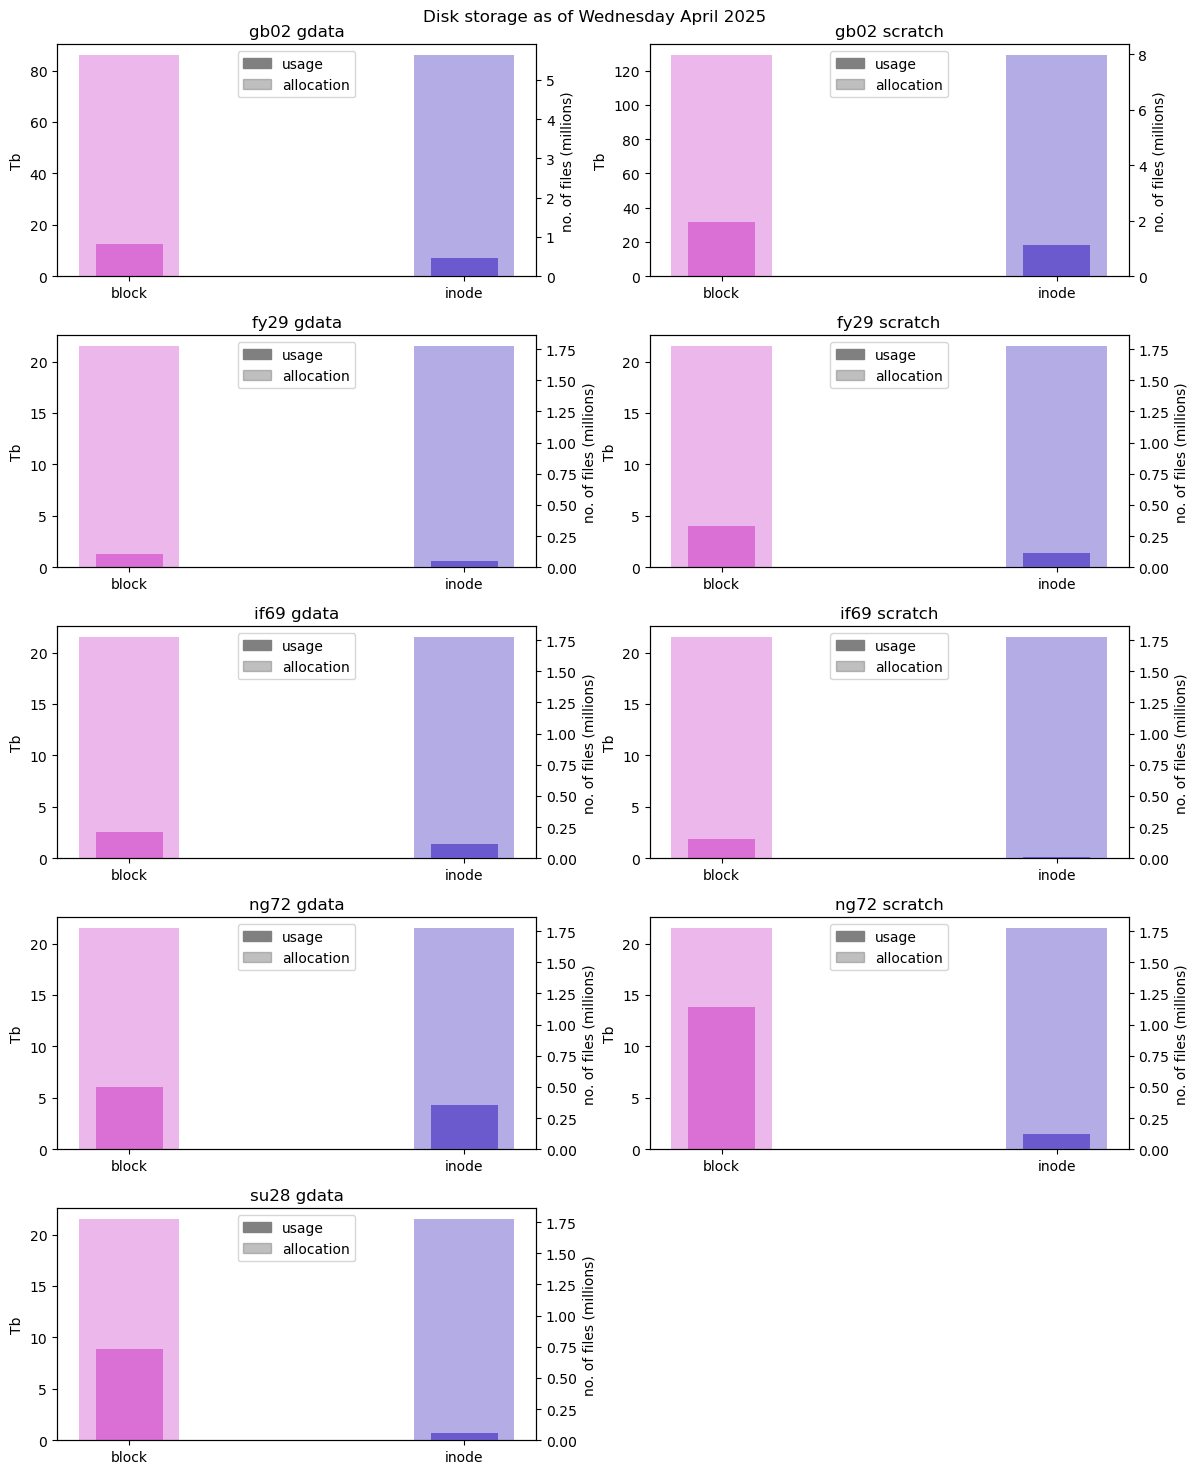

In [8]:
num_columns=2
num_rows = len(COE_PROJECTS)    
num_plots = sum(len(v) for v in storage_dict.values())
    
Position = range(1,num_plots+1)

fig_height = num_rows*3
fig_width = 12

fig = plt.figure(figsize=(fig_width,fig_height))
k = 0

for project in COE_PROJECTS:
    for disk in storage_data[project].keys():

        ax = fig.add_subplot(num_rows, num_columns, Position[k])
        ax.bar(x=['block'],height=storage_data[project][disk]['usage'].loc['block'],width=0.2,label='usage',color='orchid')
        ax.bar(x=['block'],height=storage_data[project][disk]['allocation'].loc['block'],alpha=0.5,width=0.3,label='allocation',color='orchid')
        ax2=ax.twinx()
        ax2.bar(x=['inode'],height=storage_data[project][disk]['usage'].loc['inode'],width=0.2,label='usage',color='slateblue')
        ax2.bar(x=['inode'],height=storage_data[project][disk]['allocation'].loc['inode'],alpha=0.5,width=0.3,color='slateblue',label='allocation')
        ax.yaxis.set_label_text('Tb')
        ax2.yaxis.set_label_text('no. of files (millions)')
        
        usage_patch=mpatches.Patch(color='grey',label='usage')
        alloc_patch=mpatches.Patch(color='grey',alpha=0.5,label='allocation')
        ax.legend(handles=[usage_patch,alloc_patch],loc=9)
        ax.set_title(f'{project} {disk}')

        k+= 1

fig.suptitle(f"Disk storage as of {dt.datetime.today().strftime('%A %B %Y')}")
plt.tight_layout()

In [9]:
# Find the largest individual users (this takes a while)
du_dict = {}

if USE_DU: # This is set in config.py
    
    for project in COE_PROJECTS:
        command = f'du -s /g/data/{project}/* | sort -h'
        print (f' INFO : Executing {command}')
        output_numeric = subprocess.run(command, capture_output=True, shell=True)
        c=output_numeric.stdout.decode('utf-8').splitlines()
        
        # Split the output and create a dictionary
        d = {}
        for x in c:
            d[x.split('/')[-1]] = x.split('\t')[0]
        
        du_dict[project] = d

In [10]:
if USE_DU:
    user_storage_numeric=pd.DataFrame.from_dict(du_dict)

    # Show top 10 users in tabular form convert to Tb.
    NUM_USERS=10
    for project in COE_PROJECTS:
        print (f'Top {NUM_USERS} users for /g/data space for {project} in Tb')
        display((user_storage_numeric[project].to_frame().dropna().astype('int').sort_values(project)/1024/1e6)[::-1][:NUM_USERS])
        print ('\n')

In [11]:
if USE_DU:
    # Plot the five largest users for each project
    fig,axes = plt.subplots(1,len(COE_PROJECTS),figsize=(15,4))
    
    for i,project in enumerate(COE_PROJECTS):    
        (user_storage_numeric[project].to_frame().dropna().astype('int').sort_values(project)/1024/1e6).T.plot.bar(stacked=True,ax=axes[i],width=0.2)
        patches, labels = axes[i].get_legend_handles_labels()
        axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1])
        axes[i].yaxis.set_label_text('Tb')
        axes[i].set_title(project)
    
    fig.suptitle(f"Leading users of disk storage as of  {dt.datetime.today().strftime('%A %B %Y')}")
    plt.tight_layout()

In [12]:
# Find the largest individual users 
import re 

du_dict = {}
headers = ['FILESYSTEM', 'SCAN DATE', 'PROJECT', 'GROUP', 'USER', 'SPACE USED', 'TOTAL SIZE', 'COUNT']

def convert_size_to_bytes(size_str):
    """
    Converts size strings like '24.6T', '66.1K', '200.1G' to bytes (float).
    """
    size_str = size_str.strip().upper()
    if size_str.endswith('K'):
        return float(size_str[:-1]) * 1024
    elif size_str.endswith('M'):
        return float(size_str[:-1]) * 1024**2
    elif size_str.endswith('G'):
        return float(size_str[:-1]) * 1024**3
    elif size_str.endswith('T'):
        return float(size_str[:-1]) * 1024**4
    elif size_str.endswith('B'):
        return float(size_str[:-1])  # bytes already
    else:
        # If there's no suffix, assume it's in bytes
        return float(size_str)

for project in COE_PROJECTS:
    command = f'nci-files-report -S --project {project} --filesystem gdata'
    #print (f' INFO : Executing {command}')
    output_numeric = subprocess.run(command, capture_output=True, shell=True)
    c=output_numeric.stdout.decode('utf-8').splitlines()
    parsed_data = [re.split(r'\s{2,}|\s(?=\d)', line.strip()) for line in c]
    
    # Split the output and create a dictionary
    d = df = pd.DataFrame(parsed_data[1:], columns = headers)
    d = d.set_index('USER')
    d['TOTAL SIZE'] = d['TOTAL SIZE'].apply(convert_size_to_bytes)
    
    du_dict[project] = d

user_storage_numeric=pd.concat(du_dict)['TOTAL SIZE']

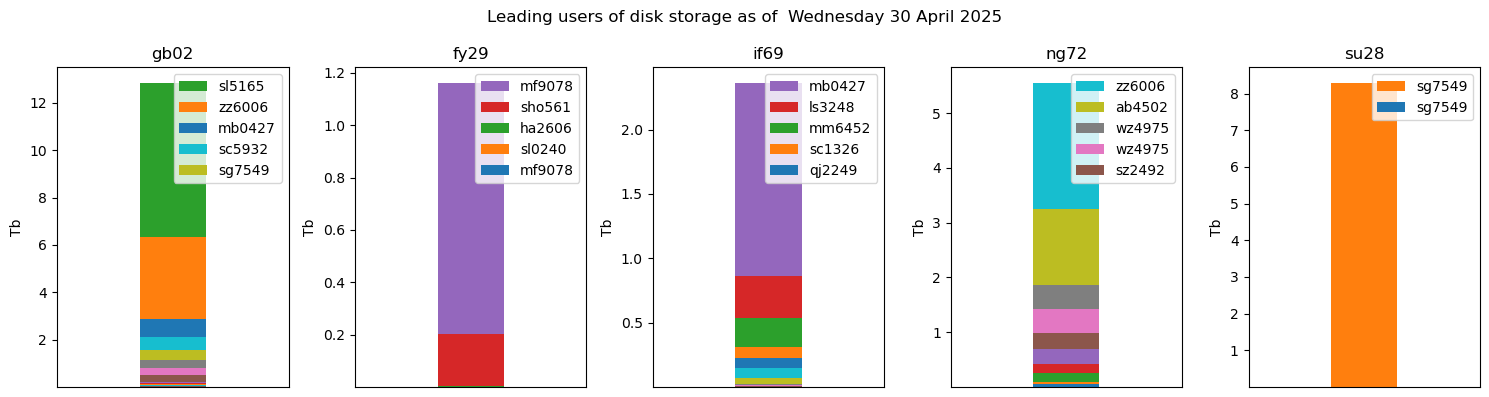

In [14]:
fig,axes = plt.subplots(1,len(COE_PROJECTS),figsize=(15,4))

for i,project in enumerate(COE_PROJECTS):    
    (user_storage_numeric[project].to_frame().dropna().astype('int').sort_values('TOTAL SIZE')/1024**4).T.plot.bar(stacked=True,ax=axes[i],width=0.2)
    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1])
    axes[i].yaxis.set_label_text('Tb')
    axes[i].get_xaxis().set_ticks([])
    axes[i].set_title(project)

fig.suptitle(f"Leading users of disk storage as of  {dt.datetime.today().strftime('%A %d %B %Y')}")
plt.tight_layout()